In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from transformers import AutoTokenizer
from tqdm import tqdm

## klue/bert-base model 및 tokenizer 불러오기

In [14]:
# ==========================================
# 1. 데이터 로드 및 변환
# ==========================================

# 파일 경로 설정
train_file_path = "/Users/jian_lee/Desktop/aiffel/data/HuggingFace/ratings_train.txt"
test_file_path = "/Users/jian_lee/Desktop/aiffel/data/HuggingFace/ratings_test.txt"

# 데이터 불러오기
train_df = pd.read_csv(train_file_path, delimiter='\t', keep_default_na=False)
test_df = pd.read_csv(test_file_path, delimiter='\t', keep_default_na=False)

# DataFrame을 Python 딕셔너리로 변환
train_dict = {
    "id": train_df["id"].tolist(),
    "text": train_df["document"].tolist(),
    "label": train_df["label"].tolist(),
}

test_dict = {
    "id": test_df["id"].tolist(),
    "text": test_df["document"].tolist(),
    "label": test_df["label"].tolist(),
}

In [15]:
# ==========================================
# 2. 모델과 토크나이저 불러오기
# ==========================================

# 사용할 모델 이름 지정 (KLUE BERT Base 모델)
MODEL_NAME = "klue/bert-base"

# 사전 학습된 KLUE BERT 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 사전 학습된 KLUE BERT 모델 로드
# num_labels=2 → 감성 분석(긍정/부정) 이진 분류를 위해 출력 레이블을 2개로 설정
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# ==========================================
# 3. 커스텀 데이터셋 클래스 정의
# ==========================================

class NSMCDataset(Dataset):
    """
    NSMC 감성 분석 데이터셋을 PyTorch Dataset 형식으로 변환하는 클래스.
    """
    def __init__(self, data_dict, tokenizer, max_length=128):
        """
        데이터셋 초기화 함수.

        Args:
            data_dict (dict): {"text": 텍스트 리스트, "label": 레이블 리스트}
            tokenizer: KLUE BERT 토크나이저
            max_length (int): 최대 시퀀스 길이 (기본값: 128)
        """
        self.texts = data_dict["text"]   # 텍스트 데이터 리스트
        self.labels = data_dict["label"] # 라벨 (0: 부정, 1: 긍정)
        self.tokenizer = tokenizer       # 토크나이저 설정
        self.max_length = max_length     # 최대 길이 설정

    def __len__(self):
        """
        데이터셋의 총 샘플 개수를 반환.

        Returns:
            int: 데이터셋 크기
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        인덱스(idx)에 해당하는 샘플을 반환.

        Args:
            idx (int): 데이터 인덱스
        
        Returns:
            dict: 모델 입력을 위한 input_ids, attention_mask, label
        """
        encoding = self.tokenizer(
            self.texts[idx], 
            padding="max_length",  # 고정된 길이로 패딩
            truncation=True,       # 초과 길이 자르기
            max_length=self.max_length,  # 최대 길이 설정
            return_tensors="pt"    # PyTorch 텐서 반환
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # 차원 축소 (batch 차원 제거)
            "attention_mask": encoding["attention_mask"].squeeze(0),  # attention mask
            "label": torch.tensor(self.labels[idx], dtype=torch.long)  # 레이블을 PyTorch 텐서로 변환
        }

In [17]:
# ==========================================
# 4. 훈련 및 테스트 데이터셋 생성
# ==========================================

# NSMC 데이터셋을 커스텀 PyTorch Dataset 클래스로 변환
train_dataset = NSMCDataset(train_dict, tokenizer)
test_dataset = NSMCDataset(test_dict, tokenizer)

In [18]:
# ==========================================
# 5. DataLoader 설정
# ==========================================

# DataLoader를 생성하여 배치 단위로 데이터 로딩
# shuffle=True → 데이터 순서를 랜덤으로 섞음 (훈련 데이터용)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# shuffle=False → 순차적으로 데이터 로딩 (테스트 데이터용)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
# ==========================================
# 6. 모델을 실행할 디바이스 설정 (MPS 지원 추가)
# ==========================================

# Mac MPS 지원을 확인하고, 가능한 경우 GPU 사용
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Mac의 GPU (Apple Silicon)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU 사용 가능할 때
else:
    device = torch.device("cpu")  # GPU 사용 불가능할 때 CPU로 실행

# 모델을 해당 디바이스로 이동
model.to(device)

# 현재 사용 중인 디바이스 출력
print(f"Using device: {device}")

Using device: mps


In [20]:
# ==========================================
# 7. DataLoader를 사용한 샘플 배치 확인
# ==========================================

# 훈련 데이터에서 첫 번째 배치를 가져와 출력
for batch in train_loader:
    print(batch)  # 'input_ids', 'attention_mask', 'label'이 포함됨
    break  # 첫 번째 배치만 확인

{'input_ids': tensor([[    2,  5401,  2259,  ...,     0,     0,     0],
        [    2, 24637,  2337,  ...,     0,     0,     0],
        [    2,  1453,    97,  ...,     0,     0,     0],
        ...,
        [    2,  7478,  2318,  ...,     0,     0,     0],
        [    2,  1443,    18,  ...,     0,     0,     0],
        [    2,  5736,  2079,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1])}


## 모델 학습

In [21]:
# ==========================================
# 1. 데이터 로드 및 변환
# ==========================================

# 🔥 수정: train_test_split() 사용하여 DataFrame 유지
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 사용할 모델 이름 지정 (KLUE BERT Base 모델)
MODEL_NAME = "klue/bert-base"

# 사전 학습된 KLUE BERT 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [22]:
# ==========================================
# 2. 데이터 전처리 및 토큰화
# ==========================================

class NSMCDataset(Dataset):
    """
    NSMC 감성 분석 데이터셋을 PyTorch Dataset 형식으로 변환하는 클래스.
    """
    def __init__(self, dataset, tokenizer, max_length=128):
        """
        데이터셋 초기화 함수.

        Args:
            dataset (DataFrame): 데이터셋 (train/val)
            tokenizer: KLUE BERT 토크나이저
            max_length (int): 최대 시퀀스 길이 (기본값: 128)
        """
        self.texts = dataset["document"].tolist()
        self.labels = dataset["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Train/Validation 데이터셋 변환
train_dataset = NSMCDataset(train_df, tokenizer)
val_dataset = NSMCDataset(val_df, tokenizer)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [23]:
# ==========================================
# 3. 모델 및 학습 설정
# ==========================================

# KLUE BERT 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# GPU 설정 (Mac MPS 지원 포함)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)

# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 스케줄러 설정 (학습률 감소)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# ==========================================
# 4. 모델 학습 진행 (Fine-tuning)
# ==========================================

EPOCHS = 3  # 학습 반복 횟수

train_losses = []  # Training Loss 저장
val_losses = []  # Validation Loss 저장
val_accuracies = []  # Validation Accuracy 저장

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # ====== Training ======
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        batch = {key: value.to(device) for key, value in batch.items()}

        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = criterion(outputs.logits, batch["label"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # ====== Validation ======
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {key: value.to(device) for key, value in batch.items()}

            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = criterion(outputs.logits, batch["label"])
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch["label"]).sum().item()
            total += batch["label"].size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct / total * 100
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

print("\nFine-tuning 완료!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Epoch 1/3


100%|██████████| 7500/7500 [1:06:54<00:00,  1.87it/s]


Training Loss: 0.2913
Validation Loss: 0.2547
Validation Accuracy: 89.40%

Epoch 2/3


100%|██████████| 7500/7500 [58:04<00:00,  2.15it/s]


Training Loss: 0.1783
Validation Loss: 0.2482
Validation Accuracy: 90.15%

Epoch 3/3


100%|██████████| 7500/7500 [57:55<00:00,  2.16it/s]


Training Loss: 0.0828
Validation Loss: 0.3315
Validation Accuracy: 90.09%

Fine-tuning 완료!


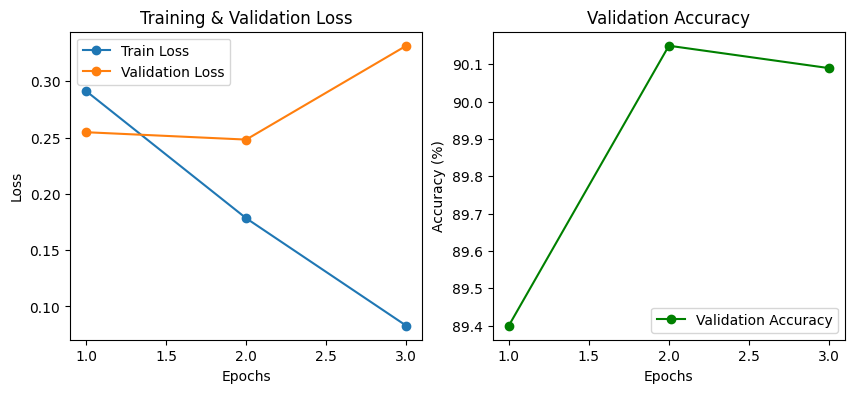

In [25]:
# ==========================================
# 5. Loss 및 Accuracy 시각화
# ==========================================

plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_accuracies, label="Validation Accuracy", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

## 테스트 데이터 평가

In [26]:
# ==========================================
# 1. 테스트 데이터 전처리
# ==========================================

# 테스트 데이터셋 변환
test_dataset = NSMCDataset(test_df, tokenizer)

# DataLoader 설정 (shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
# ==========================================
# 2. 모델 평가 (Test Set)
# ==========================================

# 모델을 평가 모드로 설정
model.eval()

# 테스트 손실 및 정확도 변수 초기화
test_loss = 0
correct = 0
total = 0

# 손실 함수 (이전과 동일하게 사용)
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():  # 평가 시에는 Gradient 계산 X
    for batch in test_loader:
        batch = {key: value.to(device) for key, value in batch.items()}

        # 모델 예측 수행
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = criterion(outputs.logits, batch["label"])
        test_loss += loss.item()

        # 예측 결과 확인
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == batch["label"]).sum().item()
        total += batch["label"].size(0)

# 평균 테스트 손실 및 정확도 계산
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total * 100

In [28]:
# ==========================================
# 3. 테스트 결과 출력
# ==========================================

print("\n 테스트 데이터 평가 완료!")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


 테스트 데이터 평가 완료!
Test Loss: 0.3291
Test Accuracy: 90.20%


---

## 회고

- 학습시간이 1에폭당 평균적으로 1시간 가량 걸림.

- 학습 결과 validation과 test 모두 정확도가 90% 이상 나오는 모습을 보이고 있음.